In [22]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



### Read test data

In [23]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    images.append(img)
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
images = np.array(images) / 255.0
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 1)

### Load the best saved model, evaluate test data

In [24]:
# model = load_model('best_model.keras')
model = load_model('best_model_res.keras')
# model = load_model('best_model_unet.keras')

In [25]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filepath",
    y_col="label"
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Keep order for reproducibility
)

# Evaluate the model
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Found 1695 validated image filenames belonging to 2 classes.


C:\Users\mary9\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - accuracy: 0.9092 - auc_1: 0.4694 - loss: 0.2513 - precision: 0.9113 - recall: 0.9968
Test Loss: 0.3387
Test Accuracy: 0.8702
Test AUC: 0.7885
Test Precision: 0.8723
Test Recall: 0.9966


## 

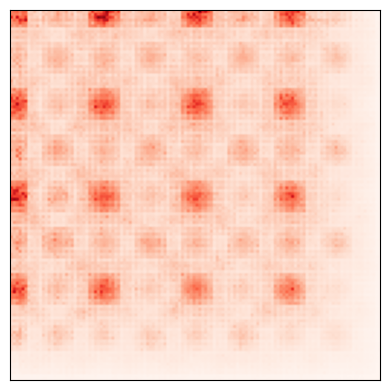

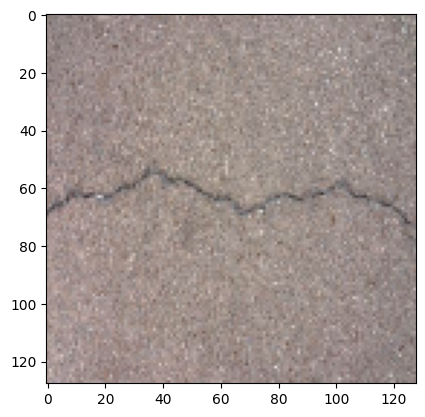

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import random


def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    return None

def apply_modifications(model):
    model = tf.keras.models.clone_model(model)
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Activation) and layer.activation == tf.keras.activations.linear:
            layer.activation = tf.keras.activations.linear
    return model


index = random.randint(0,len(images)-1)
img = images[15]
# print(img, img.shape)
# img = tf.keras.preprocessing.image.load_img('test/images/'+ random.sample(os.listdir(testing_dog), 1)[0],target_size=(300,300))
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# swap last layer with linear layer  
layer_idx = find_layer_idx(model, model.layers[-1].name)
model.layers[-1].activation = tf.keras.activations.linear
model = apply_modifications(model)

from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
# score = CategoricalScore([0])
score = BinaryScore(0.0)

#Create Saliency object
saliency = Saliency(model, clone=False)

subplot_args = {
   'nrows': 1,
   'ncols': 1,
   'figsize': (5, 4),
   'subplot_kw': {'xticks': [], 'yticks': []}
}

# Generate saliency map
saliency_map = saliency(score, x, smooth_samples=100, smooth_noise=0.2)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
ax.imshow(saliency_map[0], cmap='Reds')
plt.tight_layout()
plt.show()

plt.imshow(np.array(img))